In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import pandas as pd
import numpy as np
import xarray as xr
from sklearn.model_selection import train_test_split
from models import model_factory, inception
from utils import train_test_split_preserve_distr
from tqdm import tqdm
import csv
import os
from sklearn.metrics import r2_score
from pyCompare2 import blandAltman
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Setting up the style using seaborn
sns.set_style("whitegrid", {"grid.color": ".9"})
sns.set_context("paper", font_scale=1, rc={"axes.linewidth": 1.5})

aug_name = 'all_batch64_trans5'

orig_input_shape=(128, 128, 1)
target_input_shape=(96, 96, 1)

# load .csv with information on file names
test_df = pd.read_csv('data/ibtracs/ibtracs_gridsat_test_results.csv')

# models
model_no_augs = model_factory(model_name='InceptionV3', input_shape=target_input_shape)
model_no_augs.load_weights(filepath=f'saved_weights/no_augs.hdf5')

model_naive = model_factory(model_name='InceptionV3', input_shape=target_input_shape)
model_naive.load_weights(filepath=f'saved_weights/all_augs_nogini.hdf5')

model_all_augs = model_factory(model_name='InceptionV3', input_shape=target_input_shape)
model_all_augs.load_weights(filepath=f'saved_weights/all_augs.hdf5')

# model_all_augs_no_gini = model_factory(model_name='InceptionV3', input_shape=target_input_shape)
# model_all_augs_no_gini.load_weights(filepath=f'saved_weights/all_augs_no_gini.hdf5')

In [2]:
def load_data(idx):
    with xr.open_dataset(f'data/gridsat_cropped/GRIDSAT.{idx}.nc') as data:
        irwin = data['irwin_cdr'].data[0]
        irwin = normalize_to_range(irwin)
        irwin = crop(irwin)
        irwin = np.expand_dims(irwin, axis=-1)
        #irwin = np.repeat(np.expand_dims(irwin, axis=-1), 3, axis=-1)
    y = test_df.loc[test_df['IDX_TRUE'] == idx].WMO_WIND.values[0]
    y = np.array(y)
    return irwin, y

def normalize_to_range(arr, lower_bound=0, upper_bound=255):
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    # Normalize to [0, 1]
    normalized = (arr - arr_min) / (arr_max - arr_min + 1e-7)
    # Scale to [lower_bound, upper_bound]
    scaled = normalized * (upper_bound - lower_bound) + lower_bound
    return scaled

def crop(array, crop=target_input_shape[0]):
    center = np.array(array.shape) / 2
    x1, y1 = center - crop//2
    x2, y2 = center + crop//2
    cropped_array = array[int(x1):int(x2), int(y1):int(y2)]
    return cropped_array

def categorize(wind_speed):
    if wind_speed < 34:
        return 'TD'
    elif 34 <= wind_speed <= 63:
        return 'TS'
    elif 64 <= wind_speed <= 82:
        return 'Cat1'
    elif 83 <= wind_speed <= 95:
        return 'Cat2'
    elif 96 <= wind_speed <= 112:
        return 'Cat3'
    elif 113 <= wind_speed <= 135:
        return 'Cat4'
    else: # wind_speed > 135
        return 'Cat5'
    
categories = ['TD', 'TS', 'Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'All']
stratified_errors = {cat:[] for cat in categories}
stratified_rmse = {cat:None for cat in categories}
stratified_std = {cat:None for cat in categories}

In [3]:
# for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
#     # Load data
#     idx_true = test_df.loc[idx, 'IDX_TRUE']
#     x, y_true = load_data(idx_true)
#     x = np.expand_dims(x, axis=0)
    
#     y_no_augs = model_no_augs.predict(x, verbose=0)
#     error_no_augs = y_no_augs - y_true
#     test_df.loc[idx, f'NO_AUGS_WIND'] = y_no_augs
#     test_df.loc[idx, f'NO_AUGS_ERR'] = error_no_augs
    
#     y_naive = model_naive.predict(x, verbose=0)
#     error_naive = y_naive - y_true
#     test_df.loc[idx, f'NAIVE_WIND'] = y_naive
#     test_df.loc[idx, f'NAIVE_ERR'] = error_naive
    
#     y_all_augs = model_all_augs.predict(x, verbose=0)
#     error_all_augs = y_all_augs - y_true
#     test_df.loc[idx, f'ALL_AUGS_WIND'] = y_all_augs
#     test_df.loc[idx, f'ALL_AUGS_ERR'] = error_all_augs

In [4]:
# test_df.to_csv('data/ibtracs/ibtracs_gridsat_test_results.csv')

In [5]:
wind_true = np.array(test_df['WMO_WIND'].to_list())
wind_true_hurr = wind_true[wind_true >= 65]

wind_no_augs = np.array(test_df['NO_AUGS_WIND'].to_list())
wind_no_augs_hurr = wind_no_augs[wind_true >= 65]

wind_naive = np.array(test_df['NAIVE_WIND'].to_list())
wind_naive_hurr = wind_naive[wind_true >= 65]

wind_all_augs = np.array(test_df['ALL_AUGS_WIND'].to_list())
wind_all_augs_hurr = wind_all_augs[wind_true >= 65]

In [6]:
def plot_hexbins(x, y, xlabel, ylabel):
    x_hurr = x[x>=65]
    y_hurr = y[x>=65]
    # Set up the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

    # Common parameters for hexbin
    hexbin_params = dict(gridsize=50, cmap='viridis', mincnt=1)

    # Plot for the first dataset
    hb1 = axes[0].hexbin(x, y, **hexbin_params)
    m1, b1 = np.polyfit(x, y, 1)
    axes[0].plot(x, [m1*xi + b1 for xi in x], color='red', linewidth=3)
    r2_1 = r2_score(y, [m1*xi + b1 for xi in x])
    axes[0].text(0.05, 0.95, f'R² = {r2_1:.2f}', transform=axes[0].transAxes, fontsize=15, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))
    cbar = fig.colorbar(hb1, ax=axes[0])
    cbar.set_label('Frequency', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    
    # Plot for the second dataset
    hb2 = axes[1].hexbin(x_hurr, y_hurr, **hexbin_params)
    m2, b2 = np.polyfit(x_hurr, y_hurr, 1)
    axes[1].plot(x_hurr, [m2*x_hurr_i + b2 for x_hurr_i in x_hurr], color='red', linewidth=3)
    r2_2 = r2_score(y_hurr, [m2*x_hurr_i + b2 for x_hurr_i in x_hurr])
    axes[1].text(0.05, 0.95, f'R² = {r2_2:.2f}', transform=axes[1].transAxes, fontsize=15, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))
    cbar = fig.colorbar(hb2, ax=axes[1])
    cbar.set_label('Frequency', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    
    # Labels and titles
    axes[0].set_xlabel(xlabel, fontsize=16)
    axes[0].set_ylabel(ylabel, fontsize=16)
    axes[0].set_title('All categories', fontsize=20)
    axes[1].set_ylabel(ylabel, fontsize=16)
    axes[1].set_xlabel(xlabel, fontsize=16)
    axes[1].set_title('Cat 1 or higher', fontsize=20)

    plt.show()

In [7]:
def plot_hexbins(x, y, xlabel, ylabel):
    # Dataset filtering for hurricanes (Cat 1 or higher)
    x_hurr = x[x > 65]
    y_hurr = y[x > 65]
    
    #sns.set_style("whitegrid", {"grid.color": ".9"})
    # Set up the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

    # Common parameters for hexbin
    hexbin_params = dict(gridsize=50, cmap='viridis', mincnt=1)
    datasets = [(x, y), (x_hurr, y_hurr)]
    titles = ['All categories', 'Cat 1 or higher']

    for i, ax in enumerate(axes):
        x_data, y_data = datasets[i]
        
        # Plot hexbins
        hb = ax.hexbin(x_data, y_data, **hexbin_params)
        cbar = fig.colorbar(hb, ax=ax)
        cbar.set_label('Frequency', fontsize=14)
        cbar.ax.tick_params(labelsize=12)
        cbar.outline.set_visible(False)
        
        # Linear regression
        m, b = np.polyfit(x_data, y_data, 1)
        ax.plot(x_data, m*x_data + b, color='red', linewidth=3)
        
        # R-squared value
        r2 = r2_score(y_data, m*x_data + b)
        ax.text(
            0.05, 0.95, f'R² = {r2:.2f}',
            transform=ax.transAxes,
            fontsize=15,
            verticalalignment='top',
            bbox=dict(
                boxstyle='round, pad=0.5',
                facecolor='white',
                alpha=0.5,
                linewidth=1,
                edgecolor='grey'
            )
        )
        
        # Axes labels and title
        ax.set_xlabel(xlabel, fontsize=16)
        ax.set_ylabel(ylabel, fontsize=16)
        ax.set_title(titles[i], fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylim(10, 150)

    plt.show()

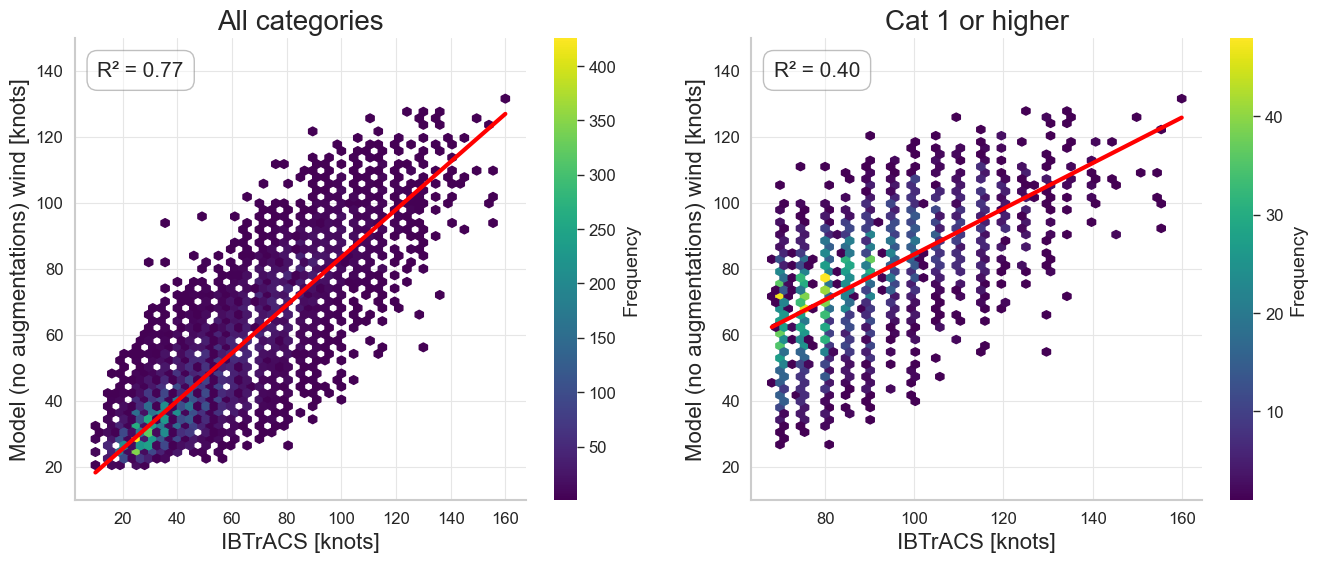

In [8]:
plot_hexbins(
    x=wind_true, xlabel='IBTrACS [knots]',
    y=wind_no_augs, ylabel ='Model (no augmentations) wind [knots]'
)

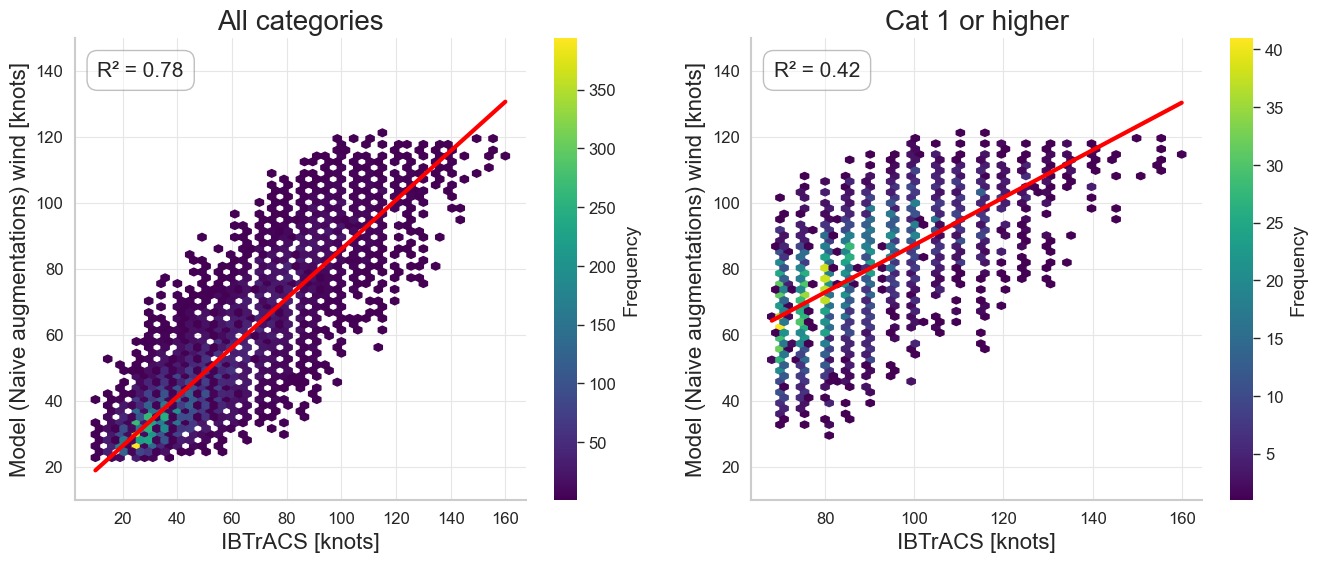

In [9]:
plot_hexbins(
    x=wind_true, xlabel='IBTrACS [knots]',
    y=wind_naive, ylabel ='Model (Naive augmentations) wind [knots]'
)

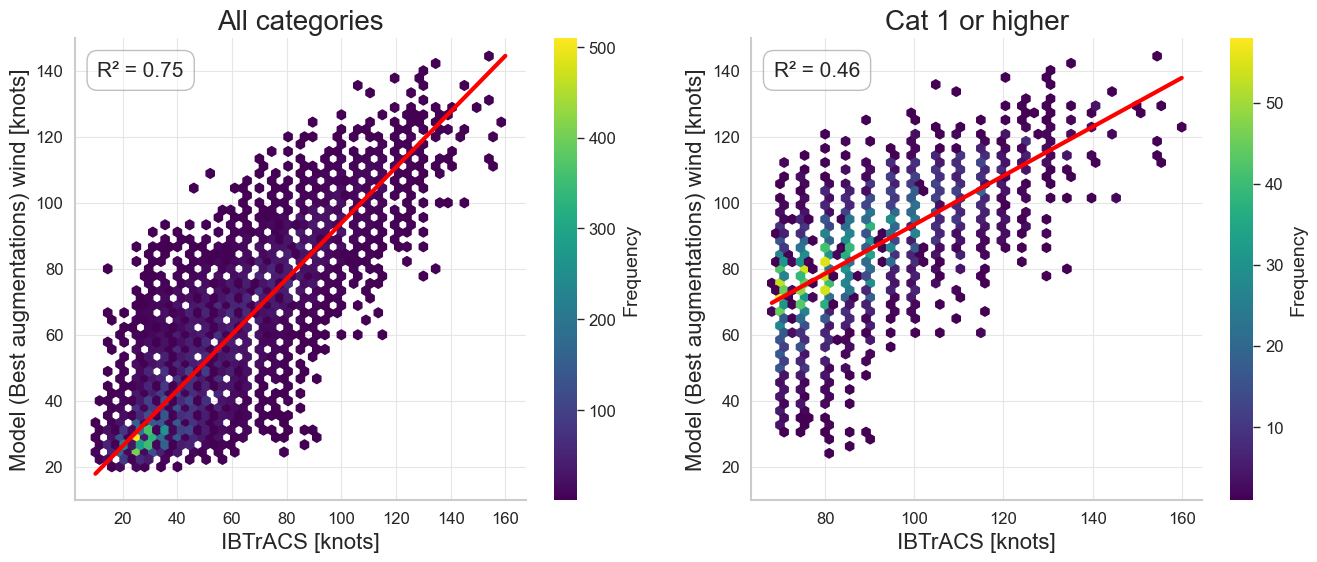

In [24]:
plot_hexbins(
    x=wind_true, xlabel='IBTrACS [knots]',
    y=wind_all_augs, ylabel ='Model (Best augmentations) wind [knots]'
)

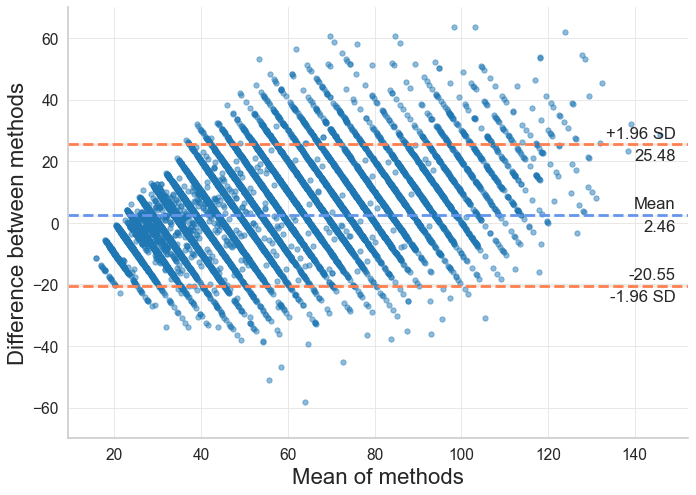

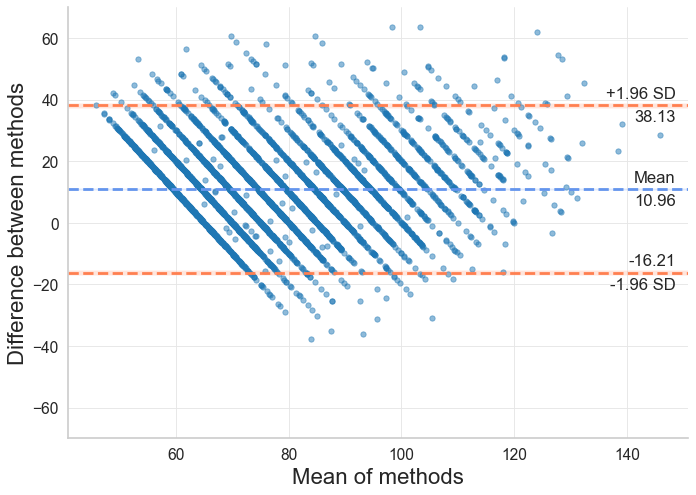

In [11]:
blandAltman(wind_true, wind_no_augs, y_axis_range=[-70, 70])
blandAltman(wind_true_hurr, wind_no_augs_hurr, y_axis_range=[-70, 70])

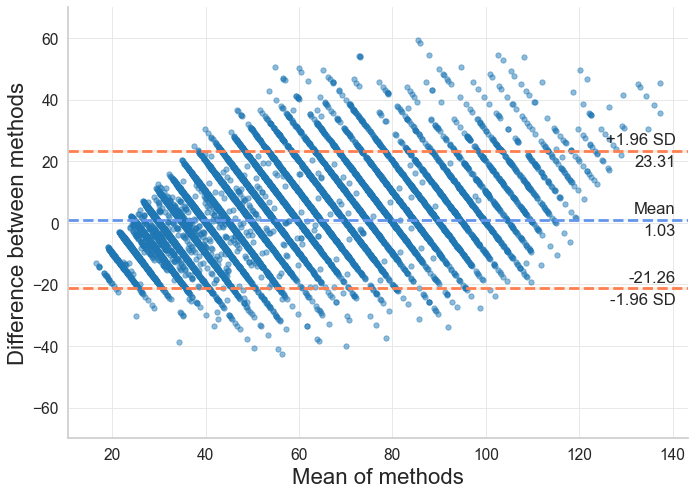

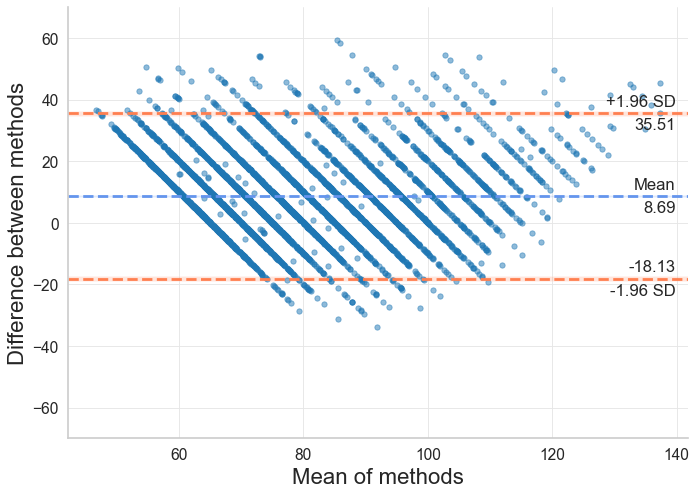

In [12]:
blandAltman(wind_true, wind_naive, y_axis_range=[-70, 70])
blandAltman(wind_true_hurr, wind_naive_hurr, y_axis_range=[-70, 70])

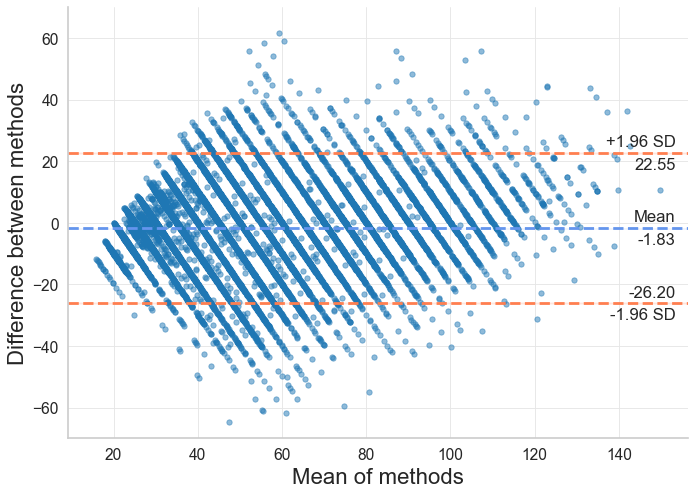

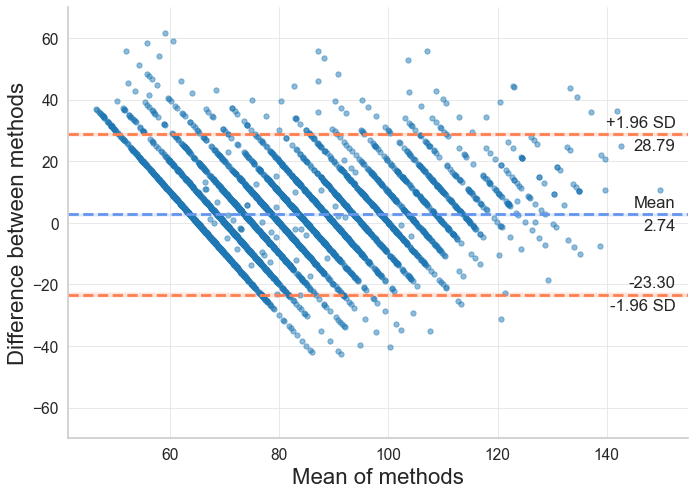

In [13]:
blandAltman(wind_true, wind_all_augs, y_axis_range=[-70, 70])
blandAltman(wind_true_hurr, wind_all_augs_hurr, y_axis_range=[-70, 70])

In [29]:
def plot_binned_errors(df, bin_length):
    min_wind = np.min(df['WMO_WIND'])
    max_wind = np.max(df['WMO_WIND'])
    
    binned_errors_all = []
    binned_errors_no = []
    binned_errors_naive = []
    confidence_all = []
    confidence_no = []
    confidence_naive = []

    # Calculate means and 95% confidence intervals
    for wind_bin in range(min_wind, max_wind, bin_length):
        ibtracs_wind = df.loc[(test_df['WMO_WIND'] >= wind_bin) & (df['WMO_WIND'] < wind_bin+bin_length)]
        all_diff =  ibtracs_wind['ALL_AUGS_WIND'] - ibtracs_wind['WMO_WIND']
        no_diff = ibtracs_wind['NO_AUGS_WIND'] - ibtracs_wind['WMO_WIND']
        naive_diff = ibtracs_wind['NAIVE_WIND'] - ibtracs_wind['WMO_WIND']
        # Means
        binned_errors_all.append(np.mean(all_diff))
        binned_errors_no.append(np.mean(no_diff))
        binned_errors_naive.append(np.mean(naive_diff))

        # 95% Confidence Intervals
        confidence_all.append(stats.sem(all_diff) * stats.t.ppf((1 + 0.95) / 2., len(all_diff)-1))
        confidence_no.append(stats.sem(no_diff) * stats.t.ppf((1 + 0.95) / 2., len(no_diff)-1))
        confidence_naive.append(stats.sem(naive_diff) * stats.t.ppf((1 + 0.95) / 2., len(naive_diff)-1))

    x_values = list(range(min_wind, max_wind, bin_length))

    # Start plotting
    plt.figure(figsize=(8, 6))
    
    categories = [
        ('TD', 0, 33),
        ('TS', 34, 63),
        ('Cat 1', 64, 82),
        ('Cat 2', 83, 95),
        ('Cat 3', 96, 112),
        ('Cat 4', 113, 136),
        ('Cat 5', 137, max_wind)
    ]

    # Colors for the bands
    colors = ['white', '#e0e0e0']  # Alternating between light grey and white

    # Add background shading for each category with labels
    for i, (label, start, end) in enumerate(categories):
        plt.axvspan(start, end, color=colors[i % 2], alpha=0.5)
        plt.text((start+end)/2, plt.gca().get_ylim()[1] + 30, label,
                 horizontalalignment='center', fontsize=12, alpha=0.7, color='black')
    
    plt.plot(x_values, binned_errors_all, label='Best augmentations', color='#1f77b4', lw=3)
    plt.fill_between(x_values, np.array(binned_errors_all) - np.array(confidence_all), np.array(binned_errors_all) + np.array(confidence_all), color='#1f77b4', alpha=0.3)

    plt.plot(x_values, binned_errors_no, label='No augmentations', color='#ff7f0e', lw=3)
    plt.fill_between(x_values, np.array(binned_errors_no) - np.array(confidence_no), np.array(binned_errors_no) + np.array(confidence_no), color='#ff7f0e', alpha=0.3)
    
    plt.plot(x_values, binned_errors_naive, label='Naive augmentations', color='#7BB390', lw=3)
    plt.fill_between(x_values, np.array(binned_errors_naive) - np.array(confidence_naive), np.array(binned_errors_naive) + np.array(confidence_naive), color='#7BB390', alpha=0.3)
    
    # Enhancing plot with customizations
    plt.xlabel('Wind Speed [knots]', fontsize=18)
    plt.ylabel('Mean Error [knots]', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(-120, 40)
    plt.legend(loc='lower left', fontsize=16)
    plt.tight_layout()

    # Adding a decorative element
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    plt.show()


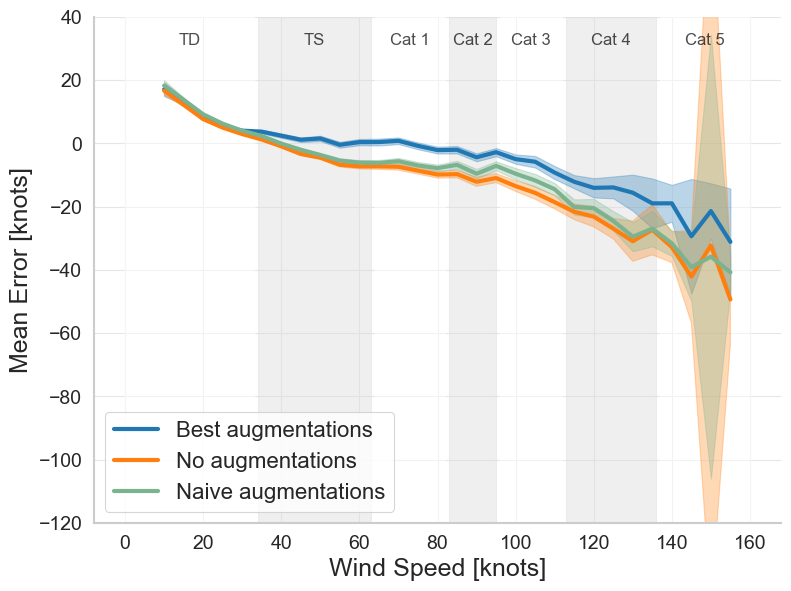

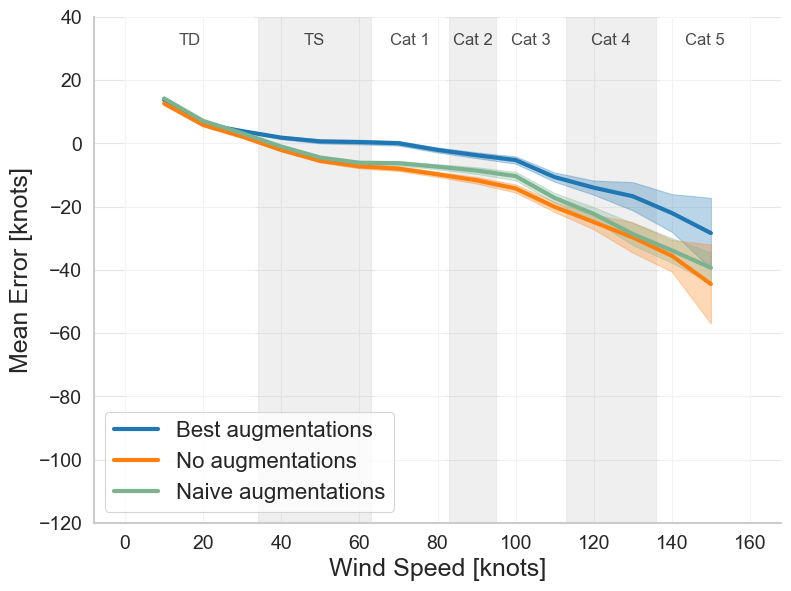

In [30]:
plot_binned_errors(test_df, bin_length=5)
plot_binned_errors(test_df, bin_length=10)

In [16]:
def plot_boxplots_by_category(df):
    # Define the categories
    categories = [
        ('TD', 0, 33),
        ('TS', 34, 63),
        ('Cat 1', 64, 82),
        ('Cat 2', 83, 95),
        ('Cat 3', 96, 112),
        ('Cat 4', 113, 136),
        ('Cat 5', 137, 200)  # Adjust the upper limit as needed
    ]
    
    all_aug_diffs = []
    no_aug_diffs = []

    # Collecting data for each category
    for _, min_wind, max_wind in categories:
        category_winds = df[(df['WMO_WIND'] >= min_wind) & (df['WMO_WIND'] <= max_wind)]
        all_aug_diff = category_winds['ALL_AUGS_WIND'] - category_winds['WMO_WIND']
        no_aug_diff = category_winds['NO_AUGS_WIND'] - category_winds['WMO_WIND']
        
        all_aug_diffs.append(all_aug_diff)
        no_aug_diffs.append(no_aug_diff)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    
    positions = np.arange(len(categories)) * 2 + 1  # Set positions for the boxplots

    # Customizing the boxplots for 'All Augmentations'
    bp1 = ax.boxplot(all_aug_diffs, positions=positions - 0.4, widths=0.6, patch_artist=True,
                     boxprops=dict(facecolor="#1E76B4", linewidth=.75),
                     meanline=False,
                     showcaps=True, whiskerprops=dict(linewidth=.75))
    for median in bp1['medians']:
        median.set_color('black')

    # Customizing the boxplots for 'No Augmentations'
    bp2 = ax.boxplot(no_aug_diffs, positions=positions + 0.4, widths=0.6, patch_artist=True,
                     boxprops=dict(facecolor="#FF7C09", linewidth=.75),
                     meanline=False,
                     showcaps=True, whiskerprops=dict(linewidth=.75))
    for median in bp2['medians']:
        median.set_color('black')
        
    # Removing vertical lines separating categories
    # Comment out or remove the following loop if you decide not to have these lines
    for pos in positions:
        ax.axvline(x=pos + 1, color='grey', linestyle='--', linewidth=0.75, alpha=0.7)

    # Set x-tick labels
    plt.xticks(positions, [label for label, _, _ in categories], fontsize=14)

    # Customizing the plot
    ax.set_ylabel('Bias [knots]', fontsize=18)
    ax.set_title('Comparison of Wind Speed Errors by Category', fontsize=16)
    
    # Creating custom legend patches with facecolor for the patch color and edgecolor for the outline
    legend_all_aug = mpatches.Patch(facecolor="#1E76B4", edgecolor='black', label='Best augmentations', linewidth=0.5)
    legend_no_aug = mpatches.Patch(facecolor="#FF7C09", edgecolor='black', label='No augmentations', linewidth=0.5)

    # Adding the custom legend patches to the legend
    ax.legend(handles=[legend_all_aug, legend_no_aug], loc='upper right', fontsize=16, edgecolor='grey', framealpha=0.7, frameon=True, borderpad=1)


    # Improving clarity of x-axis
    ax.set_xlim(0, positions[-1] + 1)

    # Only horizontal grid lines will be shown
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)
    ax.xaxis.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Thicker legend border
    #for spine in ax.legend().get_frame().spines.values():
    #    spine.set_linewidth(1.5)
    plt.yticks(fontsize=14)  # Makes y-tick labels larger
    plt.show()

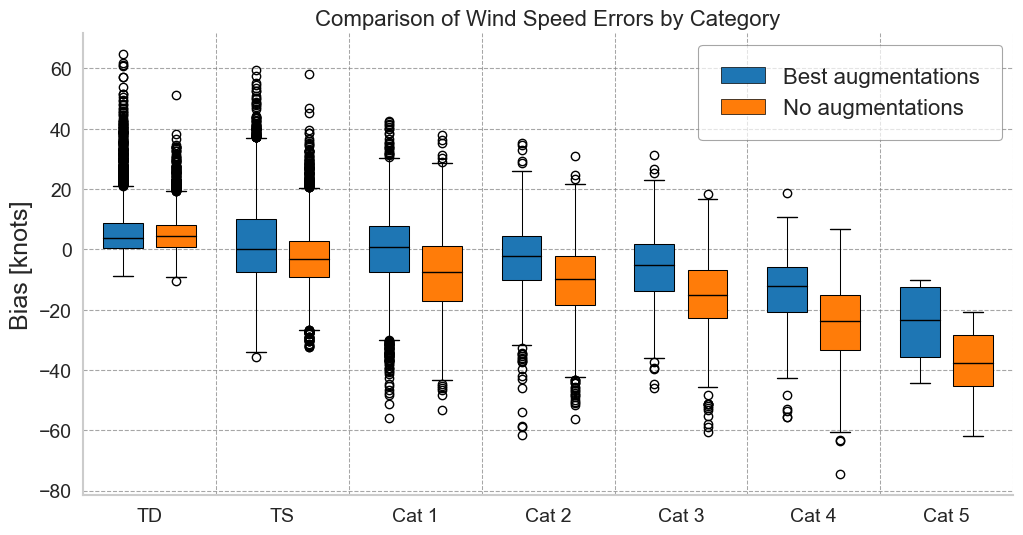

In [17]:
plot_boxplots_by_category(test_df)

In [22]:
def plot_boxplots_by_category_triplet(df):
    # Define the categories
    categories = [
        ('TD', 0, 33),
        ('TS', 34, 63),
        ('Cat 1', 64, 82),
        ('Cat 2', 83, 95),
        ('Cat 3', 96, 112),
        ('Cat 4', 113, 136),
        ('Cat 5', 137, 200)  # Adjust the upper limit as needed
    ]
    
    all_aug_diffs = []
    no_aug_diffs = []
    naive_diffs = []

    # Collecting data for each category
    for _, min_wind, max_wind in categories:
        category_winds = df[(df['WMO_WIND'] >= min_wind) & (df['WMO_WIND'] <= max_wind)]
        all_aug_diff = category_winds['ALL_AUGS_WIND'] - category_winds['WMO_WIND']
        no_aug_diff = category_winds['NO_AUGS_WIND'] - category_winds['WMO_WIND']
        naive_diff = category_winds['NAIVE_WIND'] - category_winds['WMO_WIND']
        
        all_aug_diffs.append(all_aug_diff)
        no_aug_diffs.append(no_aug_diff)
        naive_diffs.append(naive_diff)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    
    positions = np.arange(len(categories)) * 2.5 + 1.5  # Set positions for the boxplots

    # Customizing the boxplots for 'All Augmentations'
    bp1 = ax.boxplot(all_aug_diffs, positions=positions - 0.9, widths=0.6, patch_artist=True,
                     boxprops=dict(facecolor="#1E76B4", linewidth=.75),
                     meanline=False,
                     showcaps=True, whiskerprops=dict(linewidth=.75))
    for median in bp1['medians']:
        median.set_color('black')
    
        
    # Customizing the boxplots for 'Naive Augmentations'
    bp2 = ax.boxplot(naive_diffs, positions=positions -0.2, widths=0.6, patch_artist=True,
                     boxprops=dict(facecolor="#7BB390", linewidth=.75),
                     meanline=False,
                     showcaps=True, whiskerprops=dict(linewidth=.75))
    for median in bp2['medians']:
        median.set_color('black')
        
    # Customizing the boxplots for 'No Augmentations'
    bp3 = ax.boxplot(no_aug_diffs, positions=positions + 0.5, widths=0.6, patch_artist=True,
                     boxprops=dict(facecolor="#FF7C09", linewidth=.75),
                     meanline=False,
                     showcaps=True, whiskerprops=dict(linewidth=.75))
    for median in bp3['medians']:
        median.set_color('black')
        
    # Removing vertical lines separating categories
    # Comment out or remove the following loop if you decide not to have these lines
    for pos in positions:
        ax.axvline(x=pos + 1, color='grey', linestyle='--', linewidth=0.75, alpha=0.7)

    # Set x-tick labels
    plt.xticks(positions, [label for label, _, _ in categories], fontsize=14)

    # Customizing the plot
    ax.set_ylabel('Bias [knots]', fontsize=18)
    #ax.set_title('Comparison of Wind Speed Errors by Category', fontsize=16)
    
    # Creating custom legend patches with facecolor for the patch color and edgecolor for the outline
    legend_all_aug = mpatches.Patch(facecolor="#1E76B4", edgecolor='black', label='Best augmentations', linewidth=0.5)
    legend_naive = mpatches.Patch(facecolor="#7BB390", edgecolor='black', label='Naive augmentations', linewidth=0.5)
    legend_no_aug = mpatches.Patch(facecolor="#FF7C09", edgecolor='black', label='No augmentations', linewidth=0.5)

    # Adding the custom legend patches to the legend
    ax.legend(handles=[legend_all_aug, legend_naive, legend_no_aug], loc='upper right', fontsize=16, edgecolor='grey', framealpha=0.7, frameon=True, borderpad=1)


    # Improving clarity of x-axis
    ax.set_xlim(0, positions[-1] + 1)

    # Only horizontal grid lines will be shown
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)
    ax.xaxis.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.yticks(fontsize=14)  # Makes y-tick labels larger
    plt.show()

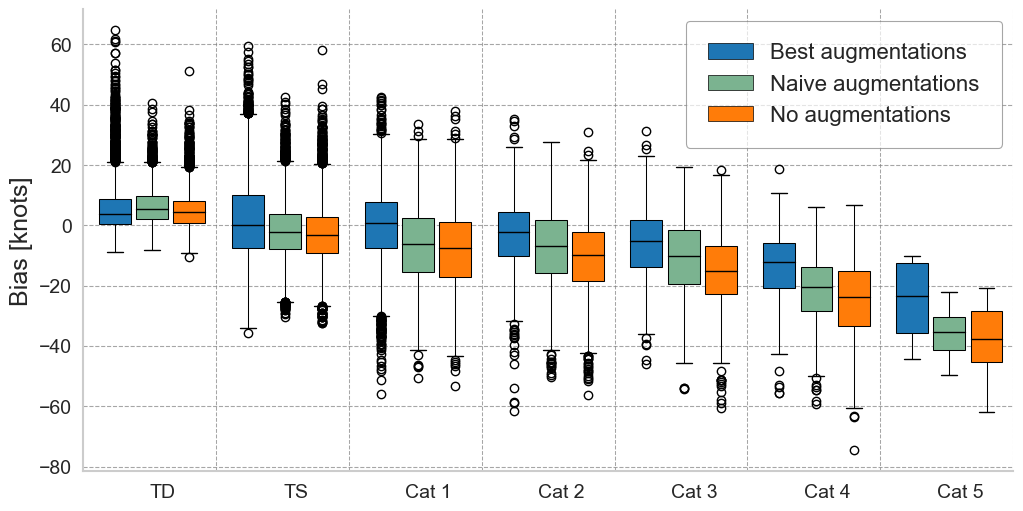

In [23]:
plot_boxplots_by_category_triplet(test_df)